In [1]:
from portiloopml.portiloop_python.ANN.data.mass_data_new import SubjectLoader, MassDataset
import os
import torch

dataset_path='/project/MASS/mass_spindles_dataset/'
loader = SubjectLoader(
    os.path.join(dataset_path, 'subject_info.csv'))
subjects = loader.select_random_subjects(1)
dataset = MassDataset(
    dataset_path,
    subjects=subjects,
    window_size=54,
    seq_stride=42,
    seq_len=1,
    use_filtered=True)
signal = torch.from_numpy(dataset.data[list(dataset.data.keys())[0]]['signal'])


Time taken to load 01-05-0019: 5.091063022613525
Time taken to create lookup table: 1.779808521270752
Number of sampleable indices: 8113947
Number of spindles: 160850
Number of N1: 540000
Number of N2: 3205000
Number of N3: 1280000
Number of R: 1595000
Number of W: 1405000


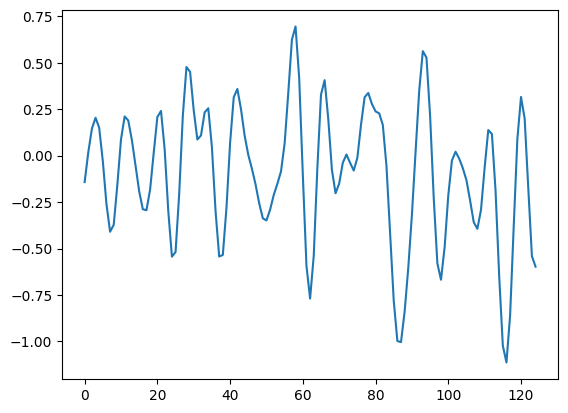

In [2]:
from matplotlib import pyplot as plt
plt.plot(signal[125:250])

In [3]:
import numpy as np

def generate_sine_waves(frequencies, n, sample_rate=250):
    # Create a time array
    t = torch.linspace(0, n, int(n * sample_rate))

    # Generate sine waves
    sine_waves = [torch.cos(2 * torch.pi * frequency * t) for frequency in frequencies]

    # Revert the sine waves
    sine_waves = torch.stack([torch.flip(sine_wave, [0]) for sine_wave in sine_waves])

    return sine_waves

sines = generate_sine_waves([11, 12, 13, 14, 15, 16], 0.5, sample_rate=250)

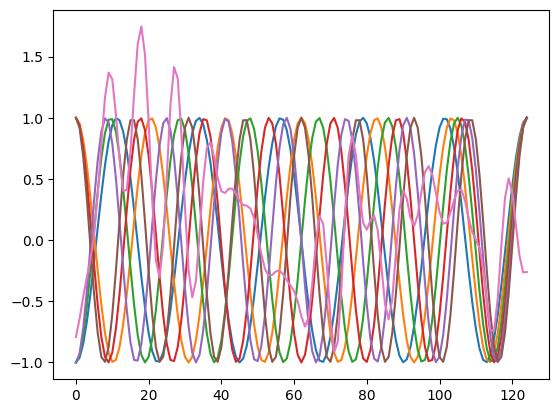

In [4]:
for sine in sines:
    plt.plot(sine)

# signal.shape
plt.plot(signal[:sines.shape[1]])

In [5]:
window_size = len(sines[0])
dot_products = []

# Split the signal into consecutive windows of size window_size using a numpy function
signal_split = signal.unfold(0, window_size, 1).float()

# Do the dot product between the signal and the sine waves
result = signal_split @ sines.T

# Keep only the maximum value for each window
result = result.max(dim=1)[0]

# Pad the begginning with zeros
result = torch.cat([torch.zeros(signal.shape[0] - result.shape[0]), result])

threshold = 1.5
# Look for values where previous value is under the threshold and current value is over the threshold
peaks = (result[:-1] < threshold) & (result[1:] > threshold)

In [6]:
import numpy as np
from scipy.signal import hilbert

# Compute the analytic signal
analytic_signal_split = hilbert(signal_split[:100, :])

# Compute the instantaneous phase
instantaneous_phase_split = np.angle(analytic_signal_split)
instantaneous_phase_split = instantaneous_phase_split[:, -1]
instantaneous_phase_split = torch.cat([torch.zeros(signal.shape[0] - instantaneous_phase_split.shape[0]), torch.from_numpy(instantaneous_phase_split).float()])

analytic_signal = hilbert(signal)
instantaneous_phase = np.angle(analytic_signal[:1000])

# peaks_hilbert = ((instantaneous_phase[:-1] < 0) & (instantaneous_phase[1:] > 0))
# peaks_hilbert = peaks_hilbert[:, -1]

# peaks_hilbert = torch.cat([torch.zeros(signal.shape[0] - peaks_hilbert.shape[0]), torch.from_numpy(peaks_hilbert).float()])

: 

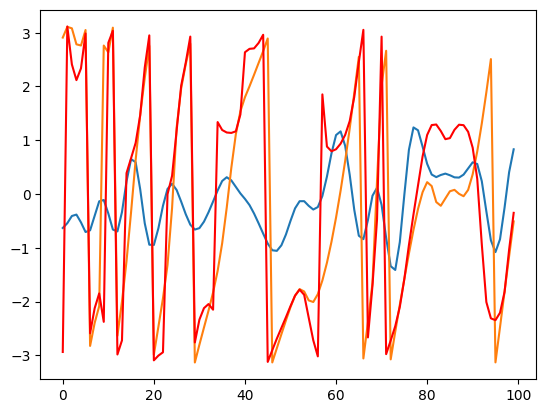

In [178]:
size = 100
start = 500
plt.plot(signal[start:start + size])
# plt.plot(result[start:start + size])
plt.plot(instantaneous_phase[start:start + size])
plt.plot(instantaneous_phase_split[start:start + size], color='red')
# for i in range(start, start + size):
#     if peaks_hilbert[i]:
#         plt.axvline(i - start, color='red')

In [199]:
import time

times = []
for i in range(1000):
    start = time.time()
    res = hilbert(signal_split[0])
    # print(time.time() - start)
    times.append(time.time() - start)

print(f"Average time : {np.mean(times)}")


Average time : 5.151534080505371e-05
